In [1]:
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
# download dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings

mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
mnist['data'].shape, mnist['target'].shape

((70000, 784), (70000,))

In [4]:
X_train, X_test, y_train, y_test = mnist['data'][:60000],mnist['data'][60000:], mnist['target'][:60000], mnist['target'][60000:]

### Use KNN

In [30]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier() 

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5, 6], 'metric':['minkowski','manhattan']}]

from sklearn.model_selection import GridSearchCV
grid_cv = GridSearchCV(knn_clf, param_grid, cv=4, verbose=3, n_jobs=-1)

In [31]:
grid_cv.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 141.4min
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed: 346.3min finished


GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'metric': ['minkowski', 'manhattan'],
                          'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [32]:
grid_cv.best_params_

{'metric': 'minkowski', 'n_neighbors': 4, 'weights': 'distance'}

In [33]:
grid_cv.best_score_

0.9713166666666667

In [34]:
y_train_hat = grid_cv.best_estimator_.predict(X_train)
from sklearn.metrics import accuracy_score
accuracy_score(y_train_hat, y_train)

1.0

In [36]:
y_test_hat = grid_cv.predict(X_test)
accuracy_score(y_test_hat, y_test)

0.9714

### Use SVC

In [5]:
# shuffle training set
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [7]:
svm_clf = SVC(
    C=1.0,
    kernel='rbf',
    degree=3,
    gamma='scale',
    coef0=0.0,
    tol=0.001,
    random_state=0,
)
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

In [8]:
y_train_hat = svm_clf.predict(X_train_scaled)
from sklearn.metrics import accuracy_score
accuracy_score(y_train_hat, y_train)

0.9485166666666667

##### use cross validation to fune hyperparameters, use smaller training set

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=3.5988934774124326, gamma=0.001513186272679838 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=3.5988934774124326, gamma=0.001513186272679838, total=   1.1s
[CV] C=3.5988934774124326, gamma=0.001513186272679838 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] . C=3.5988934774124326, gamma=0.001513186272679838, total=   0.9s
[CV] C=3.5988934774124326, gamma=0.001513186272679838 ................
[CV] . C=3.5988934774124326, gamma=0.001513186272679838, total=   1.2s
[CV] C=3.055855399572819, gamma=0.06719156480223124 ..................
[CV] ... C=3.055855399572819, gamma=0.06719156480223124, total=   1.3s
[CV] C=3.055855399572819, gamma=0.06719156480223124 ..................
[CV] ... C=3.055855399572819, gamma=0.06719156480223124, total=   1.3s
[CV] C=3.055855399572819, gamma=0.06719156480223124 ..................
[CV] ... C=3.055855399572819, gamma=0.06719156480223124, total=   1.3s
[CV] C=1.107005900704854, gamma=0.001848939794318145 .................
[CV] .. C=1.107005900704854, gamma=0.001848939794318145, total=   1.1s
[CV] C=1.107005900704854, gamma=0.001848939794318145 .................
[CV] .. C=1.107005900704854, gamma=0.001848939794318145, total=   1.0s
[CV] C=1.107005900704854, gamma=0.001848939794318145 .................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   38.6s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=0,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A25AA32848>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A25AA331C8>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [10]:
print(rnd_search_cv.best_score_)
rnd_search_cv.best_params_

0.8680087272901643


{'C': 6.335534109540218, 'gamma': 0.0011263118134606108}

In [16]:
# use the best params to fit the whole training set
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=6.335534109540218, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0011263118134606108, kernel='rbf', max_iter=-1, probability=False,
    random_state=0, shrinking=True, tol=0.001, verbose=False)

In [18]:
y_train_hat3 = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train_hat3, y_train)

0.9973166666666666

## Data Augumentation 

In [ ]:
from scipy.ndimage.interpolation import shift
shift?

In [49]:
np.array([(2,2,3),(1,3,5)]).reshape(-1)

array([2, 2, 3, 1, 3, 5])

In [57]:
from scipy.ndimage.interpolation import shift

def shift_img(img, dx, dy):
    """
    img: 1d-array (768,)
    """
    img_square = img.reshape(28,28)
    return shift(img_square, [dy,dx], mode='constant', cval=50).reshape(-1)

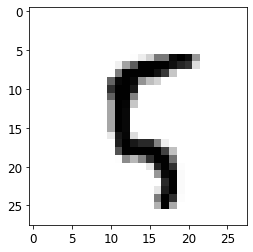

In [55]:
plt.imshow(X_train[100].reshape(28,28), cmap = mpl.cm.binary)
plt.show()

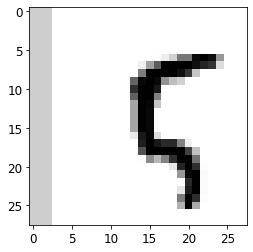

In [59]:
# test the function to see if it works
shifted = shift_img(X_train[100], 3, 0)
plt.imshow(shifted.reshape(28,28), cmap = mpl.cm.binary)
plt.show()

In [71]:
X_train_aug = [X_train]
y_train_aug = [y_train]

for mx,my in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
    # vectorize the function for all rows at the same time instead of for loops
    X_aug = np.apply_along_axis(shift_img, axis=1, arr=X_train, dx=mx, dy=my)
    X_train_aug.append(X_aug)
    # append y_train east loop along with x_aug without changing
    y_train_aug.append(y_train)
    
X_train_aug = np.concatenate(X_train_aug)
y_train_aug = np.concatenate(y_train_aug)
X_train_aug.shape, y_train_aug.shape

((300000, 784), (300000,))

In [72]:
# without refitting the grid_cv on augumented data, using the original best params to save time
knn_clf = KNeighborsClassifier(**grid_cv.best_params_)

In [74]:
knn_clf.fit(X_train_aug, y_train_aug)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [75]:
y_test_aug_hat = knn_clf.predict(X_test)

In [76]:
accuracy_score(y_test_aug_hat,y_test)

0.9771